In [11]:
#bunch of intializations- note: mask is a boolean matrix that help perform projections

import numpy as np
import matplotlib.pyplot as plt
Anan = np.genfromtxt("./MovieRankingData2024.csv", delimiter=',', filling_values=0)
A = Anan[1:, 2:]
A = np.where(A > 5, A / 2, A)
lambda_reg_vec = np.array([0.1,1,10])
k_vec = np.arange(1,8)
iter_max = 200
R_FroNorm = np.zeros(iter_max)
n, d = A.shape
mask = np.where(A == 0, 0, 1) 

In [2]:
#helper functions for solving linear least sq, and 3 different projections (really should refactor into 1 func)

def ridge(A,b,lam):
    return np.linalg.solve(A.T @A + lam * np.eye(A.shape[1]), A.T@b)  

def proj(matrix, mask=mask):
    return np.where(mask, matrix, 0)

def proj_col(matrix,vector):
    matrix_proj = matrix.copy()
    vector = np.squeeze(vector)
    mask = vector == 1
    matrix_proj[:, ~mask] = 0
    return matrix_proj

def proj_row(matrix,vector): 
    matrix_proj = matrix.copy()
    vector = np.squeeze(vector)
    mask = vector == 1
    matrix_proj[~mask,:] = 0
    return matrix_proj

In [6]:
#---------------------------------PART 1a---------------------------------
def lowRank(lambda_reg, k):
    X = np.random.rand(n, k)
    Y = np.random.rand(k, d)
    M = X @ Y
    for itr in range(iter_max):
        for i in range(n):
            Y_proj=proj_col(Y,mask[i,:])
            a_proj=proj(A[i, :], mask=mask[i,:])
            X[i, :]= ridge(Y_proj.T, a_proj,lambda_reg)
        for j in range(d):
            X_proj = proj_row(X, mask[:,j])
            a_proj = proj(A[:,j], mask=mask[:,j])
            Y[:, j]= ridge(X_proj, a_proj,lambda_reg)
        loss = 0.5 * np.linalg.norm(proj(A - X @ Y), 'fro') ** 2 + 0.5 * lambda_reg * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(Y, 'fro') ** 2)
        R_FroNorm[itr] = loss  
    # print(R_FroNorm[:40])
    M = X @ Y
    if lambda_reg == 0.1 and k==7:
        print('sample matrix:')
        print(M)
    print('lambda:', lambda_reg, 'k:', k, 'final residual:' ,R_FroNorm[199])
   

#main
for lambda_reg in lambda_reg_vec:
    print('---------------------------------------------------------------')
    for k in k_vec:
        lowRank(lambda_reg,k)

---------------------------------------------------------------
lambda: 0.1 k: 1 final residual: 445.0477026355455
lambda: 0.1 k: 2 final residual: 348.30765369533844
lambda: 0.1 k: 3 final residual: 281.5749211847189
lambda: 0.1 k: 4 final residual: 227.97499700890475
lambda: 0.1 k: 5 final residual: 190.2261206524012
lambda: 0.1 k: 6 final residual: 155.04689340298066
sample matrix:
[[ 4.51768432  4.54437786  4.56018201 ...  4.32812492  3.82302151
   3.36383957]
 [ 5.06295476  4.13224296  3.71234886 ...  4.28760369  2.8473299
   3.59587849]
 [ 3.72517966  4.39000163  4.10195417 ...  4.27736154  3.78348244
   3.4176665 ]
 ...
 [ 3.12458252  3.41183195  3.99394779 ...  3.74554961  1.98061935
   3.3586485 ]
 [ 3.04570788  4.21700929  3.34408014 ...  4.05513379  4.72339537
   2.34256013]
 [ 2.96504462  3.01989059  0.53502619 ...  1.50179666  3.79856909
  -0.22597995]]
lambda: 0.1 k: 7 final residual: 124.93289621788043
---------------------------------------------------------------
lambd

In [8]:
#---------------------------------PART 1b---------------------------------
def nuclear(lambda_reg, k):
    X = np.random.rand(n, k)
    Y = np.random.rand(k, d)
    M = X @ Y
    for itr in range(iter_max):
        U, S, Vh = np.linalg.svd(M + proj(A - M), full_matrices=False)
        S = np.maximum(S - lambda_reg, 0)  # check: element wise
        Mnew = np.dot(U * S, Vh)
        M = Mnew
        loss = 0.5 * np.linalg.norm(proj(A) - proj(M), 'fro') ** 2 + lambda_reg * np.linalg.norm(M, 'nuc')
        R_FroNorm[itr] = loss  
    # print(R_FroNorm)
    if lambda_reg == 0.1 and k==7:
        print('sample matrix:')
        print(M)
    print('lambda:', lambda_reg, 'k:', k, 'final residual:' ,R_FroNorm[199])
    
#main
for lambda_reg in lambda_reg_vec:
    for k in k_vec:
        nuclear(lambda_reg,k)

lambda: 0.1 k: 1 final residual: 34.4385646593369
lambda: 0.1 k: 2 final residual: 33.68577981430844
lambda: 0.1 k: 3 final residual: 33.04856027738888
lambda: 0.1 k: 4 final residual: 32.49325718747073
lambda: 0.1 k: 5 final residual: 31.842876802605517
lambda: 0.1 k: 6 final residual: 31.579707592058533
sample matrix:
[[4.49672467 4.00079331 4.49029372 ... 4.40386824 3.98666118 2.90921064]
 [4.99622461 3.99867433 3.99175178 ... 4.98399294 2.99784495 3.00639965]
 [4.00091768 3.90654506 4.29510739 ... 4.39325841 3.59522637 3.09912667]
 ...
 [3.50846073 3.02133093 4.48915332 ... 3.99648922 2.01571438 2.99688956]
 [3.00268309 3.01017103 3.99387926 ... 3.99390449 4.97808599 2.01353687]
 [2.37744344 3.00150115 1.54628033 ... 1.90203953 1.70263332 1.52442802]]
lambda: 0.1 k: 7 final residual: 30.872933139782152
lambda: 1.0 k: 1 final residual: 286.6516478374894
lambda: 1.0 k: 2 final residual: 286.6442240056686
lambda: 1.0 k: 3 final residual: 286.63827993169025
lambda: 1.0 k: 4 final resid

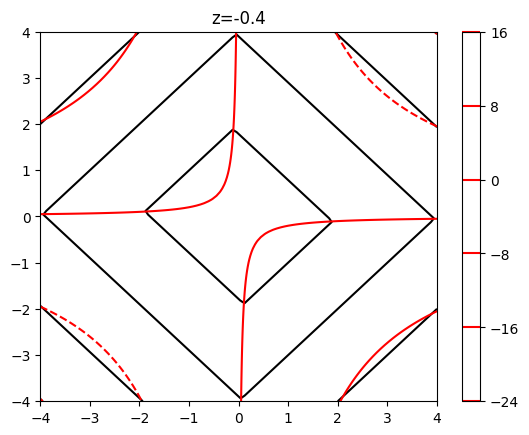

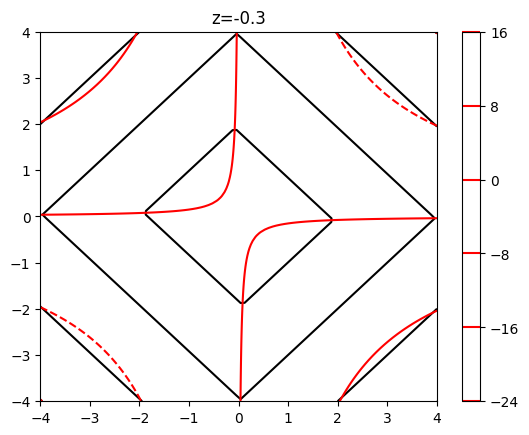

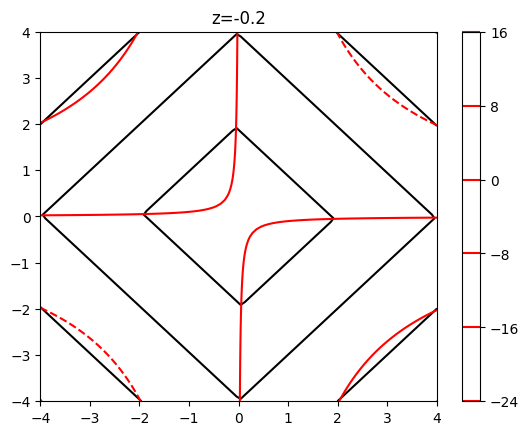

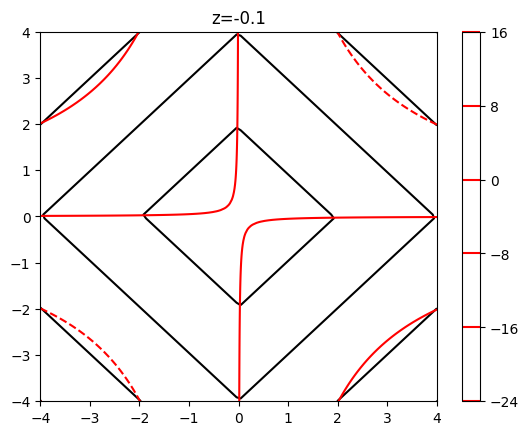

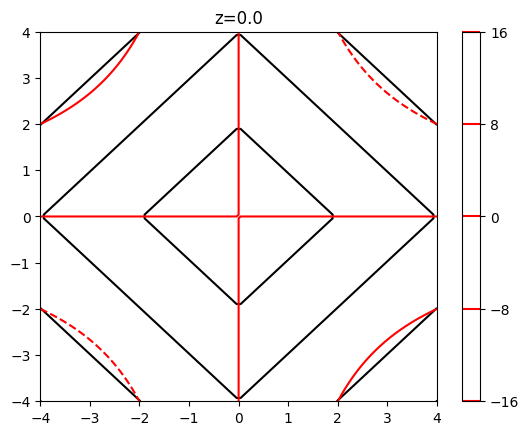

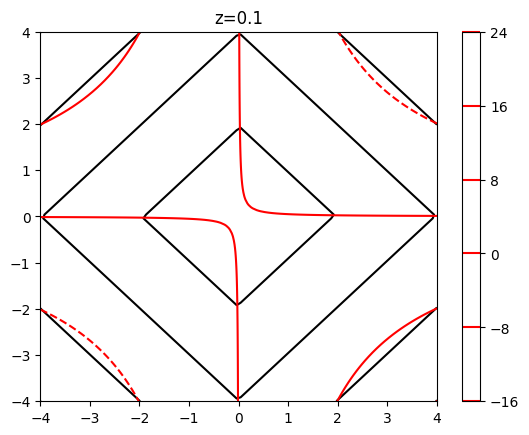

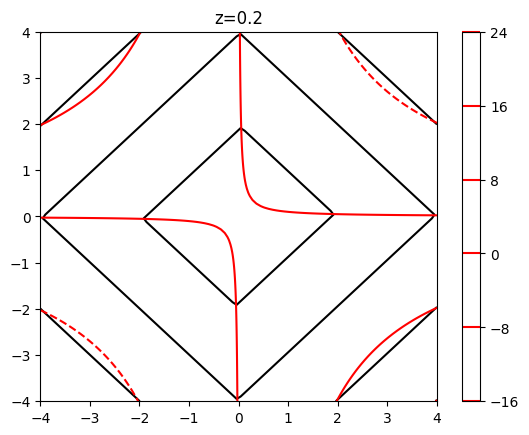

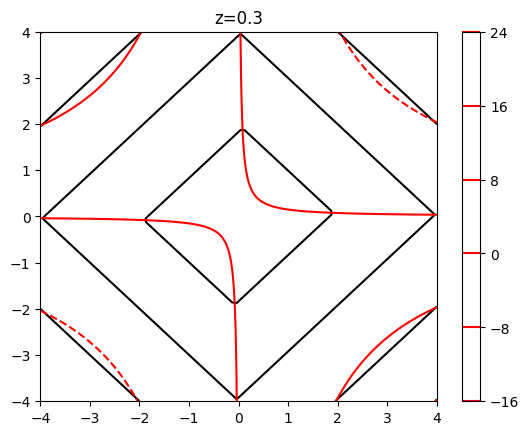

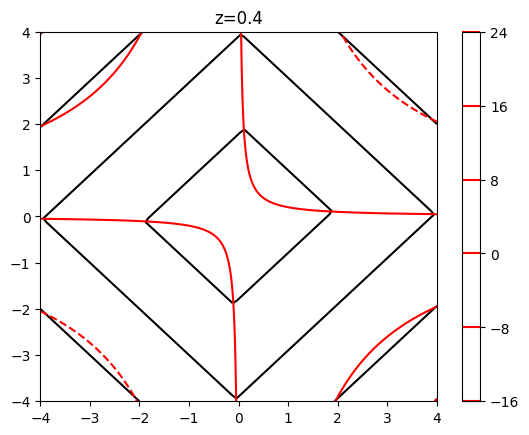

In [152]:
#---------------------------------PART 2---------------------------------
shape=4
num=100
x=np.linspace(-shape ,shape,num )
y=np.linspace(-shape, shape,num )
z_vec=np.linspace(-0.4, 0.4, 9)
X, Y = np.meshgrid(x, y)
for z in z_vec:
    plt.figure()
    det=0.5*z-X*Y
    A_tensor = np.stack((np.full(X.shape,0.5),X,Y,np.full(X.shape,z)))
    A_tensor=np.reshape(A_tensor, (2,2, num, num))
    norm= np.linalg.norm(A_tensor, 'nuc', axis=(0,1))
    plt.title('z=' + str(round(z, 1)))
    plt.contour(X,Y,norm, levels=3, colors ='black')
    plt.contour(X,Y,det, levels=3, colors='red')
    plt.colorbar()
    plt.show